## Wrangling with Spark Functions

Real data is rarely clean and ready for analysis. In this chapter learn to remove unneeded information, handle missing values and add additional data to your analysis.

## Dropping a list of columns
Our data set is rich with a lot of features, but not all are valuable. We have many that are going to be hard to wrangle into anything useful. For now, let's remove any columns that aren't immediately useful by dropping them.

- 'STREETNUMBERNUMERIC': The postal address number on the home
- 'FIREPLACES': Number of Fireplaces in the home
- 'LOTSIZEDIMENSIONS': Free text describing the lot shape
- 'LISTTYPE': Set list of values of sale type
- 'ACRES': Numeric area of lot size



In [ ]:
# File Path
file_path = ".../data/datacamp/"

# Read the file into a dataframe
df = spark.read.parquet(file_path + 'real_estate') 
# Show top 5 records
df.select('STREETNUMBERNUMERIC', 'FIREPLACES', 'LOTSIZEDIMENSIONS', 'LISTTYPE', 'ACRES').show(5)

# List of columns to remove from dataset
cols_to_drop = ['STREETNUMBERNUMERIC', 'LOTSIZEDIMENSIONS']

# Drop columns in list
df = df.drop(*cols_to_drop)

Knowing just the house number doesn't tell us anything about what value the house should be. Likewise the freeform text field is likely too messy to extract useful information from. We can always come back to these after our intial model if we need more information.

## Using text filters to remove records
It pays to have to ask your clients lots of questions and take time to understand your variables. You find out that Assumable mortgage is an unusual occurrence in the real estate industry and your client suggests you exclude them. In this exercise we will use isin() which is similar to like() but allows us to pass a list of values to use as a filter rather than a single one.

In [3]:
# Inspect unique values in the column 'ASSUMABLEMORTGAGE'
df.select(['ASSUMABLEMORTGAGE']).distinct().show()

# List of possible values containing 'yes'
yes_values = ['Yes w/ Qualifying', 'Yes w/No Qualifying']

# Filter the text values out of df but keep null values
text_filter = ~df['ASSUMABLEMORTGAGE'].isin(yes_values) | df['ASSUMABLEMORTGAGE'].isNull()
df = df.where(text_filter)

# Print count of remaining records
print(df.count())

+-------------------+
|  ASSUMABLEMORTGAGE|
+-------------------+
|               None|
|  Yes w/ Qualifying|
|      Not Assumable|
|Yes w/No Qualifying|
| Information Coming|
+-------------------+

4950


We've filtered out records that we don't wish to predict for since they are so unusual.

## Filtering numeric fields conditionally
Again, understanding the context of your data is extremely important. We want to understand what a normal range of houses sell for. Let's make sure we exclude any outlier homes that have sold for significantly more or less than the average. Here we will calculate the mean and standard deviation and use them to filer the near normal field log_SalesClosePrice.

In [4]:
from pyspark.sql.functions import mean, stddev, log

df = df.withColumn('log_SalesClosePrice', log(df.SALESCLOSEPRICE))

# Calculate values used for outlier filtering
mean_val = df.agg({'log_SalesClosePrice': 'mean'}).collect()[0][0]
stddev_val = df.agg({'log_SalesClosePrice': 'stddev'}).collect()[0][0]

# Create three standard deviation (μ ± 3σ) lower and upper bounds for data
low_bound = mean_val - (3 * stddev_val)
hi_bound = mean_val + (3 * stddev_val)

# Filter the data to fit between the lower and upper bounds
df = df.where((df['log_SalesClosePrice'] < hi_bound) & (df['log_SalesClosePrice'] > low_bound))

Awesome, now we've set proper constaints on our data. If we were to get new data, or the value for Jumbo Loans changes, we can dynamically refilter it!

## Custom Percentage Scaling
In the slides we showed how to scale the data between 0 and 1. Sometimes you may wish to scale things differently for modeling or display purposes.

In [5]:
from pyspark.sql.functions import round

# Define max and min values and collect them
max_days = df.agg({'DAYSONMARKET': 'max'}).collect()[0][0]
min_days = df.agg({'DAYSONMARKET': 'min'}).collect()[0][0]

# Create a new column based off the scaled data
df = df.withColumn('percentage_scaled_days', 
                  round((df['DAYSONMARKET'] - min_days) / (max_days - min_days)) * 100)

# Calc max and min for new column
print(df.agg({'percentage_scaled_days': 'max'}).collect())
print(df.agg({'percentage_scaled_days': 'min'}).collect())

[Row(max(percentage_scaled_days)=100.0)]
[Row(min(percentage_scaled_days)=0.0)]


## Scaling your scalers
In the previous exercise, we minmax scaled a single variable. Suppose you have a LOT of variables to scale, you don't want hundreds of lines to code for each. Let's expand on the previous exercise and make it a function.

In [6]:
def min_max_scaler(df, cols_to_scale):
  # Takes a dataframe and list of columns to minmax scale. Returns a dataframe.
  for col in cols_to_scale:
    # Define min and max values and collect them
    max_days = df.agg({col: 'max'}).collect()[0][0]
    min_days = df.agg({col: 'min'}).collect()[0][0]
    new_column_name = 'scaled_' + col
    # Create a new column based off the scaled data
    df = df.withColumn(new_column_name, 
                      (df[col] - min_days) / (max_days - min_days))
  return df

# Columns to scale
cols_to_scale = ['FOUNDATIONSIZE', 'DAYSONMARKET', 'FIREPLACES']
  
# Apply new function    
df = min_max_scaler(df, cols_to_scale)

# Show that our data is now between 0 and 1
df[['DAYSONMARKET', 'scaled_DAYSONMARKET']].show(5)

+------------+-------------------+
|DAYSONMARKET|scaled_DAYSONMARKET|
+------------+-------------------+
|          64|0.28444444444444444|
|          20|0.08888888888888889|
|          16|0.07111111111111111|
|          21|0.09333333333333334|
|          64|0.28444444444444444|
+------------+-------------------+
only showing top 5 rows



Creating scalable solutions that can be reused will free up many hours of you and your teams time. Additionally it means that you have fewer things to correct should you need to make changes.

## Correcting Right Skew Data
In the slides we showed how you might use log transforms to fix positively skewed data (data whose distribution is mostly to the left). To correct negative skew (data mostly to the right) you need to take an extra step called "reflecting" before you can apply the inverse of log, written as (1/log) to make the data look more like normal a normal distribution. Reflecting data uses the following formula to reflect each value: (xmax+1)–x.

In [7]:
# Compute the skewness
print(df.agg({'YEARBUILT': 'skewness'}).collect())

# Calculate the max year
max_year = df.agg({'YEARBUILT': 'max'}).collect()[0][0]

# Create a new column of reflected data
df = df.withColumn('Reflect_YearBuilt', (max_year + 1) - df['YEARBUILT'])

# Create a new column based reflected data
df = df.withColumn('adj_yearbuilt', 1 / log(df['Reflect_YearBuilt']))

[Row(skewness(YEARBUILT)=-0.2556934160102312)]


Adjusting variables is a complex task. What you've seen here are only a few of the ways that you might try to make your data fit a normal distribution.

## Visualizing Missing Data
Being able to plot missing values is a great way to quickly understand how much of your data is missing. It can also help highlight when variables are missing in a pattern something that will need to be handled with care lest your model be biased.

Which variable has the most missing values? Run all lines of code except the last one to determine the answer. Once you're confident, and fill out the value and hit "Submit Answer".

In [8]:
# Install a conda package in the current Jupyter kernel
import sys
!conda install --yes --prefix {sys.prefix} seaborn

from matplotlib import pyplot as plt
import seaborn as sns

Solving environment: done

# All requested packages already installed.



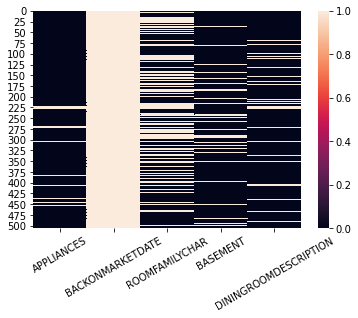

In [9]:
# Define column list to subset data
columns = ['APPLIANCES', 'BACKONMARKETDATE', 'ROOMFAMILYCHAR', 'BASEMENT', 'DININGROOMDESCRIPTION']

# Sample the dataframe and convert to Pandas
sample_df = df.select(columns).sample(False, 0.1, 42)
pandas_df = sample_df.toPandas()

# Convert all values to T/F
tf_df = pandas_df.isin(["None"]) #don't use pandas.isnull() since nulls were set to "None" : str

# Plot it
sns.heatmap(data=tf_df)
plt.xticks(rotation=30, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

# Set the answer to the column with the most missing data
answer = 'BACKONMARKETDATE'

Visuals like this can help you to quickly eliminate variables that provide no value to your analysis.

## Imputing Missing Data
Missing data happens. If we make the assumption that our data is missing completely at random, we are making the assumption that what data we do have, is a good representation of the population. If we have a few values we could remove them or we could use the mean or median as a replacement. In this exercise, we will look at 'PDOM': Days on Market at Current Price.

In [10]:
# Count missing rows
missing = df.where(df['PDOM'].isNull()).count()

# Calculate the mean value
col_mean = df.agg({'PDOM': 'mean'}).collect()[0][0]

# Replacing with the mean value for that column
df.fillna(col_mean, subset=['PDOM']).select('PDOM').show(3)

+----+
|PDOM|
+----+
|  26|
|  20|
|  14|
+----+
only showing top 3 rows



Missing value replacement is easy, however its ramifications can be huge. Make sure to spend time considering the appropriate ways to handle missing data in your problems.

## Calculate Missing Percents
Automation is the future of data science. Learning to automate some of your data preparation pays dividends. In this exercise, we will automate dropping columns if they are missing data beyond a specific threshold.

In [11]:
def column_dropper(df, threshold):
  # Takes a dataframe and threshold for missing values. Returns a dataframe.
  total_records = df.count()
  for col in df.columns:
    # Calculate the percentage of missing values
    missing = df.where(df[col].isNull()).count()
    missing_percent = missing / total_records
    # Drop column if percent of missing is more than threshold
    if missing_percent > threshold:
      df = df.drop(col)
  return df

# Drop columns that are more than 60% missing
df = column_dropper(df, 0.6)

We just assessed all of our variables for completenes in a few seconds. Additionally, this function is totally reusable for our next analysis.

## A Dangerous Join
In this exercise, we will be joining on Latitude and Longitude to bring in another dataset that measures how walk-friendly a neighborhood is. We'll need to be careful to make sure our joining columns are the same data type and ensure we are joining on the same precision (number of digits after the decimal) or our join won't work!

Below you will find that df['latitude'] and df['longitude'] are at a higher precision than walk_df['longitude'] and walk_df['latitude'] we'll need to round them to the same precision so the join will work correctly.

In [12]:
from pyspark.sql.types import *

# Load in data
latlong = spark.read \
    .schema(StructType([StructField('NO', IntegerType(), True), StructField('latitude', DoubleType(), True), StructField('longitude', DoubleType(), True)])) \
    .csv(file_path + 'latlong', header=True)
walk_df = spark.read.parquet(file_path + 'walk')
df_orig = spark.read.parquet(file_path + 'real_estate')
df_orig = df_orig.join(latlong, on=df_orig["NO"] == latlong["NO"])

# Cast data types
walk_df = walk_df.withColumn('longitude', walk_df['longitude'].cast('double'))
walk_df = walk_df.withColumn('latitude', walk_df['latitude'].cast('double'))

# Round precision
df = df_orig.withColumn('longitude', round(df_orig['longitude'], 5))
df = df.withColumn('latitude', round(df['latitude'], 5))

# Create join condition
condition = [walk_df['latitude'] == df['latitude'], walk_df['longitude'] == df['longitude']]

# Join the dataframes together
join_df = df.join(walk_df, on=condition, how='left')
# Count non-null records from new field
print(join_df.where(~join_df['walkscore'].isNull()).count())

4823


Great work, taking steps make sure that your join keys are in the same format and precision is important if you hope to get the most out of the new data set!

## Spark SQL Join
Sometimes it is much easier to write complex joins in SQL. In this exercise, we will start with the join keys already in the same format and precision but will use SparkSQL to do the joining.

In [13]:
# Register dataframes as tables
df.createOrReplaceTempView('df')
walk_df.createOrReplaceTempView('walk_df')

# SQL to join dataframes
join_sql = 	"""
			SELECT 
				*
			FROM df
			LEFT JOIN walk_df
			ON df.longitude = walk_df.longitude
			AND df.latitude = walk_df.latitude
			"""
# Perform sql join
correct_join_df = spark.sql(join_sql)

## Checking for Bad Joins
Joins can go bad silently if we are not careful, meaning they will not error out but instead return mangled data with more or less data than you'd intended. Let's take a look at a couple ways that joining incorrectly can change your data set for the worse.

In this example we will look at what happens if you join two dataframes together when the join keys are not the same precision and compare the record counts between the correct join and the incorrect one.

In [14]:
# Join on mismatched keys precision 
wrong_prec_cond = [df_orig['longitude'] == walk_df['longitude'], df_orig['latitude'] == walk_df['latitude']]
wrong_prec_df = df_orig.join(walk_df, on=wrong_prec_cond, how='left')

# Compare bad join to the correct one
print(wrong_prec_df.where(wrong_prec_df['walkscore'].isNull()).count())
print(correct_join_df.where(correct_join_df['walkscore'].isNull()).count())

# Create a join on too few keys
few_keys_cond = [df['longitude'] == walk_df['longitude']]
few_keys_df = df.join(walk_df, on=few_keys_cond, how='left')

# Compare bad join to the correct one
print("Record Count of the Too Few Keys Join Example: " + str(few_keys_df.count()))
print("Record Count of the Correct Join Example: " + str(correct_join_df.count()))

4822
0
Record Count of the Too Few Keys Join Example: 5961
Record Count of the Correct Join Example: 4823


As you can see, thinking critically about how you join your data is essential to making sure you don't mangle it!